In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mesa_reader as mr

In [2]:
%matplotlib inline

In [3]:
data = np.loadtxt('10XC068_1_50mode.txt')
p = mr.MesaData('10/LOGS/profile2.data')
R_star = p.header_data['photosphere_r']*6.955e10 # cm
M_star = p.header_data['star_mass']*1.988e33 # grams
G = 6.674e-8 # cgs

In [4]:
# data order:
# data[:,0] index
# data[:,1] ell
# data[:,2] n_p
# data[:,3] n_g
# data[:,4] eta; -1 means no driving
# data[:,5] Re(omega) in dynamical frequency
# data[:,6] Im(omega)
# data[:,7] Re(freq) in microHz
# data[:,8] Im(freq) in microHz
# data[:,9] reference position (1)
# data[:,10] Re(xi_r(ref))
# data[:,11] Im(xi_r(ref))
# data[:,12] Re(xi_h(ref)) NOTE: xi_h is not the horizontal component of xi
# data[:,13] Im(xi_h(ref))
# data[:,14] H = mode energy in G M_star^2/R_star

In [5]:
ell = data[:,1]
data_ell1 = data[ell==1,:]

In [6]:
def reorder(data):
    freq = data[:,7]
    freq_order = np.argsort(freq)
    data = data[freq_order,:]
    return data

In [7]:
data_ell1 = reorder(data_ell1)

In [8]:
# ell = 1
ell = 1
Lambda = np.sqrt(ell*(ell+1))
freq = 1e-6*data_ell1[:,7]
gamma = 1e-6*data_ell1[:,8]

In [9]:
# read in mesa data
sigma = 5.6704e-5
T = p.temperature[::-1]
rho = 10**p.logRho[::-1]
kappa = 10**p.log_opacity[::-1]
c_v = 3/2*8.314e7
Krad = (16*sigma*T**3/(3*rho**2*kappa*c_v))
r = p.radius[::-1]*6.955e10
dlogKrad_dr = np.gradient(Krad*rho,r)/(Krad*rho)
N = 10**(p.bulk_data['log_brunt_N'][::-1])
cs = p.bulk_data['csound'][::-1]

In [10]:
dr = np.gradient(r)

om_list = freq*(2*np.pi)
lamb = Lambda*cs/r

In [11]:
r_len = len(r)
def upper_boundary(boolean):
    return int(r_len/2) + np.argmax(boolean[int(r_len/2):])

In [12]:
i_RCB = np.argmax(N>1e-25)
i_CB = upper_boundary(N<1e-30)
i_turning = np.argmax(om_list[:,None]>lamb[None,:],axis=1)
i_turning[i_CB<i_turning] = i_CB
i_turning[i_turning==0] = i_CB

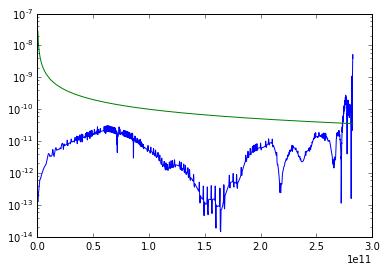

In [13]:
plt.semilogy(r,np.abs(dlogKrad_dr))
plt.semilogy(r,0*r+10/r)

In [14]:
travel_time_list = []
tau_turning1 = []
tau_turning2 = []
for j,om in enumerate(om_list):
    kr = Lambda/r*N/om
    vg = om/kr
    gamma_real1 = (kr**2 - kr*dlogKrad_dr)*Krad
    gamma_real2 = kr**2*Krad
    tau1 = np.zeros(len(r))
    tau2 = np.zeros(len(r))
    travel_time = np.zeros(len(r))
    for i in range(i_turning[j]-1):
        tau1[i+1] = tau1[i] + gamma_real1[i]/vg[i]*dr[i]
        tau2[i+1] = tau2[i] + gamma_real2[i]/vg[i]*dr[i]
        travel_time[i+1] = travel_time[i] + dr[i]/vg[i]
    travel_time_list.append(travel_time[i_turning[j]-1])
    tau_turning1.append(tau1[i_turning[j]-1])
    tau_turning2.append(tau2[i_turning[j]-1])
travel_time = np.array(travel_time_list)
tau_turning1 = np.array(tau_turning1)
tau_turning2 = np.array(tau_turning2)
gamma_WKB1 = tau_turning1/travel_time
gamma_WKB2 = tau_turning2/travel_time

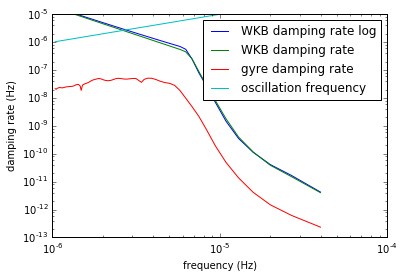

In [15]:
plt.loglog(freq,np.abs(gamma_WKB1/(2*np.pi)),label='WKB damping rate log')
plt.loglog(freq,np.abs(gamma_WKB2/(2*np.pi)),label='WKB damping rate')
plt.loglog(freq,np.abs(gamma),label='gyre damping rate')
plt.loglog(freq,freq,label='oscillation frequency')
plt.ylim([1e-13,1e-5])
plt.ylabel(r'damping rate (Hz)')
plt.xlabel(r'frequency (Hz)')
plt.legend(loc='upper right')
plt.savefig("damping_rates.png",dpi=300)